In [1]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15 
state_size = 4
num_classes = 2
echo_step = 3 
batch_size = 5 # number of sample trained in a iteration
num_batches = total_series_length//batch_size//truncated_backprop_length

In [2]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)


In [3]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])


# Please refers to 
# https://www.tensorflow.org/versions/r1.0/api_docs/python/tf/contrib/rnn/LSTMStateTuple
cell_state = tf.placeholder(tf.float32, [batch_size, state_size])
hidden_state = tf.placeholder(tf.float32, [batch_size, state_size])
init_state = tf.contrib.rnn.LSTMStateTuple(cell_state, hidden_state)
print("init_state created by LSTMStateTuple:", init_state)

init_state created by LSTMStateTuple: LSTMStateTuple(c=<tf.Tensor 'Placeholder_2:0' shape=(5, 4) dtype=float32>, h=<tf.Tensor 'Placeholder_3:0' shape=(5, 4) dtype=float32>)


In [4]:
# W and b is useless in this example, because the tensorflow will create the 
# weight for the variable in the cell.
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1, state_size)), dtype=tf.float32)


# W2 and b2 is needed as we will use this to calculate the logits of the outputs
W2 = tf.Variable(np.random.rand(state_size, num_classes), dtype=tf.float32)
b2 = tf.Variable(np.zeros((1, num_classes)), dtype=tf.float32)

In [5]:
# batchX_placeholder is in shape of (batch_size, truncated_backprop_length)
# Let's say batch_size=5, and truncated_backprop_length=15
# If we unstack the batchX_placeholder, it will have 15 of (5,) tensor.
# The rnn is trained based on this 5 batches with 15 timesteps each

# inputs_series = tf.unstack(batchX_placeholder, axis=1)
# ^ the above code is replaced by tf.split command
# tf.split will split the batchX_placeholder evenly into truncated_backprop_length
# number of tensor along the 1st-axis
# e.g. batchX_placeholder is of shape (5, 30) and truncated_backprop_length is 3
# then, there will be 10 tensors of shape (5, 3)
inputs_series = tf.split(batchX_placeholder, 15, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

print(inputs_series)

[<tf.Tensor 'split:0' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:1' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:2' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:3' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:4' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:5' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:6' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:7' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:8' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:9' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:10' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:11' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:12' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:13' shape=(5, 1) dtype=float32>, <tf.Tensor 'split:14' shape=(5, 1) dtype=float32>]


In [6]:
# This is basically the forward pass in the RNN.
# For each input in the inputs_series, we concatenate it with the state value.
# Then, we apply the same weights W and biases b on each of these input and
# find the corresponding state value in this time series. 

if False: # for reference only
    current_state = init_state
    states_series = []

    for current_input in inputs_series:
        # (5,) -> (5,1) so as to concatenate with the state
        current_input = tf.reshape(current_input, [batch_size, 1])

        # Calculate the sum of affine transform
        # By concatenating those two tensors you will only use one matrix 
        # multiplication.
        input_and_state_concatenated = tf.concat([current_input, current_state], 1)

        next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)
        states_series.append(next_state)
        current_state = next_state

In [7]:
# forward pass implemented with the help of tensorflow
# This code resembles the above 
# cell = tf.contrib.rnn.BasicRNNCell(num_units=state_size)

cell = tf.contrib.rnn.BasicLSTMCell(num_units=state_size, state_is_tuple=True)
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)

print(states_series)

[<tf.Tensor 'rnn/basic_lstm_cell/mul_2:0' shape=(5, 4) dtype=float32>, <tf.Tensor 'rnn/basic_lstm_cell_1/mul_2:0' shape=(5, 4) dtype=float32>, <tf.Tensor 'rnn/basic_lstm_cell_2/mul_2:0' shape=(5, 4) dtype=float32>, <tf.Tensor 'rnn/basic_lstm_cell_3/mul_2:0' shape=(5, 4) dtype=float32>, <tf.Tensor 'rnn/basic_lstm_cell_4/mul_2:0' shape=(5, 4) dtype=float32>, <tf.Tensor 'rnn/basic_lstm_cell_5/mul_2:0' shape=(5, 4) dtype=float32>, <tf.Tensor 'rnn/basic_lstm_cell_6/mul_2:0' shape=(5, 4) dtype=float32>, <tf.Tensor 'rnn/basic_lstm_cell_7/mul_2:0' shape=(5, 4) dtype=float32>, <tf.Tensor 'rnn/basic_lstm_cell_8/mul_2:0' shape=(5, 4) dtype=float32>, <tf.Tensor 'rnn/basic_lstm_cell_9/mul_2:0' shape=(5, 4) dtype=float32>, <tf.Tensor 'rnn/basic_lstm_cell_10/mul_2:0' shape=(5, 4) dtype=float32>, <tf.Tensor 'rnn/basic_lstm_cell_11/mul_2:0' shape=(5, 4) dtype=float32>, <tf.Tensor 'rnn/basic_lstm_cell_12/mul_2:0' shape=(5, 4) dtype=float32>, <tf.Tensor 'rnn/basic_lstm_cell_13/mul_2:0' shape=(5, 4) dtype

In [10]:
# Calculating loss

# This calculate the logits of the series X fed intp the rnn by multiplying
# the hidden state neurons with weights and adding the biases. If the truncated
# length is of 15, then the length of logits series is also of 15.
logits_series = [tf.matmul(state, W2) + b2 for state in states_series]
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)\
         for logits, labels in zip(logits_series, labels_series)]

total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

In [8]:
# visualizing the training

def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = \
        np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = \
        np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

New data, epoch 0
Step 0 Loss 0.689841
Step 100 Loss 0.59938
Step 200 Loss 0.373447
Step 300 Loss 0.292394
Step 400 Loss 0.178763
Step 500 Loss 0.0173175
Step 600 Loss 0.00868454
New data, epoch 1
Step 0 Loss 0.349732
Step 100 Loss 0.00452724
Step 200 Loss 0.00316158
Step 300 Loss 0.00236901
Step 400 Loss 0.00230271
Step 500 Loss 0.00209542
Step 600 Loss 0.00144861
New data, epoch 2
Step 0 Loss 0.537539
Step 100 Loss 0.00124516
Step 200 Loss 0.00131492
Step 300 Loss 0.00123089
Step 400 Loss 0.00113203
Step 500 Loss 0.00123177
Step 600 Loss 0.00103243
New data, epoch 3
Step 0 Loss 0.619723
Step 100 Loss 0.00112797
Step 200 Loss 0.000862249
Step 300 Loss 0.000754441
Step 400 Loss 0.000747091
Step 500 Loss 0.000606868
Step 600 Loss 0.000699063
New data, epoch 4
Step 0 Loss 0.63259
Step 100 Loss 0.000603935
Step 200 Loss 0.000743906
Step 300 Loss 0.00052439
Step 400 Loss 0.000531775
Step 500 Loss 0.000544002
Step 600 Loss 0.000507978
New data, epoch 5
Step 0 Loss 0.728764
Step 100 Loss 0.0

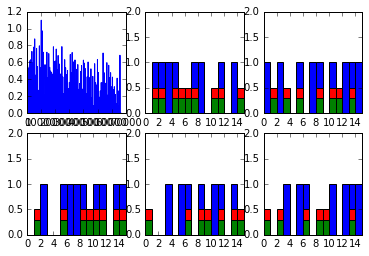

In [11]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list=[]
    
    for epoch_idx in range(num_epochs):
        x,y = generateData()
        #_current_state = np.zeros((batch_size, state_size))
        _current_cell_state = np.zeros((batch_size, state_size))
        _current_hidden_state = np.zeros((batch_size, state_size))
        
        print("New data, epoch", epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length
            
            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]
            
            _total_loss, _train_step, _current_state, _predictions_series = \
            sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder: batchX,
                    batchY_placeholder: batchY,
                    cell_state: _current_cell_state,
                    hidden_state: _current_hidden_state,
                }
            )
            # current_state is a tuple of (cell_state, hidden_state)
            _current_cell_state, _current_hidden_state = _current_state
            
            loss_list.append(_total_loss)
            
            if batch_idx%100 == 0:
                print("Step",batch_idx,"Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()

In [ ]:
current_input = inputs_series[0]
current_input = tf.reshape(current_input, [batch_size, 1])
current_state = init_state
tf.concat([current_input, current_state], 1)